# Assignment 2
By Alexandra de Carvalho and Nuno Pedrosa

## Importing Modules

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import jaccard_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Pre-Processing
### Constructing a Laplacian matrix to represent the graph 

Applying community detection for each of the ten users in the database. For that, a list is made of each ego's nodeId.

In [40]:
users = [0,107,348,414,686,698,1684,1912,3437,3980]

For each of the ten users, the friends file is read and from each line of the file, the first element (friend's Id) is extracted, to get an ordered list of the friends / nodes.

In [41]:
friends_lists = dict()                                      # dictionary {ego:[friends list]}
for ego in users:
    with open("facebook/" + str(ego) +".feat") as f:
        friends = []                                        # list of friends Id
        for line in f:
            friends += [int(line.split(" ")[0])]
    friends_lists[ego] = sorted(friends)

From the edges file, get a list of connections between nodes.

In [42]:
edges_lists = dict()                                        # dictionary {ego:[edges lists]}
for ego in users:
    with open("facebook/" + str(ego) +".edges") as f:
        edges = []                                          # [[edge],[edge]]
        for line in f:
            edges.append(list(map(int, line.strip().split(" "))))
    edges_lists[ego] = edges

#### Adjacency Matrix

For the adjacency matrix, each row/column index matches the friend's index in the friend list collected above. For each edge in the file, both Aij and Aji are be passed to 1.

In [43]:
a_matrices = dict()

for ego in users:
    adj_matrix = np.zeros((len(friends_lists[ego]), len(friends_lists[ego])))

    # adding the edges from the edges file, symetrically
    for edge in edges_lists[ego]:
        adj_matrix[friends_lists[ego].index(edge[0])][friends_lists[ego].index(edge[1])] = 1
        adj_matrix[friends_lists[ego].index(edge[1])][friends_lists[ego].index(edge[0])] = 1
    
    a_matrices[ego] = adj_matrix

#### Degree Matrix

The degree matrix can be constructed by counting the ones in the correspondent columns/rows on the adjacency matrix. The values are placed in the Aii cell, making it a diagonal matrix. 

In [44]:
d_matrices = dict()

for ego in users:
    deg_matrix = np.zeros((len(friends_lists[ego]), len(friends_lists[ego])))

    # diagonal matrix with the sum of correspondent row/column in adjacency matrix
    for row_idx in range(len(a_matrices[ego])):
        deg_matrix[row_idx][row_idx] = np.count_nonzero(a_matrices[ego][row_idx] == 1)

    d_matrices[ego] = deg_matrix

#### Laplacian Matrix

L = D - A

In [45]:
lap_decomposition = dict()

for ego in users:
    matrix = np.subtract(d_matrices[ego], a_matrices[ego])
    lap_decomposition[ego] = matrix
    print(matrix)

[[16.  0.  0. ...  0. -1.  0.]
 [ 0.  9.  0. ...  0.  0.  0.]
 [ 0.  0. 16. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 15.  0.  0.]
 [-1.  0.  0. ...  0. 26.  0.]
 [ 0.  0.  0. ...  0.  0.  6.]]
[[ 2. -1. -1. ...  0.  0.  0.]
 [-1.  3. -1. ...  0.  0.  0.]
 [-1. -1. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 40.  0. -1.]
 [ 0.  0.  0. ...  0. 30.  0.]
 [ 0.  0.  0. ... -1.  0. 38.]]
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  5.  0. ...  0.  0.  0.]
 [ 0.  0.  9. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 34.  0.  0.]
 [ 0.  0.  0. ...  0.  2.  0.]
 [ 0.  0.  0. ...  0.  0.  3.]]
[[ 3.  0. -1. ...  0.  0.  0.]
 [ 0. 12.  0. ...  0.  0.  0.]
 [-1.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 32.  0.  0.]
 [ 0.  0.  0. ...  0. 19.  0.]
 [ 0.  0.  0. ...  0.  0. 16.]]
[[27. -1.  0. ...  0.  0. -1.]
 [-1. 44.  0. ...  0.  0. -1.]
 [ 0.  0.  7. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [-1. -1.  0. ...  0.  0. 28.]]
[[17.  0. -1. ...  0.  0.  0.]
 [ 0.  8.

## Decomposition
### Computing eigenvalues and eigenvectors of the matrix 

Calculating the eigenvalues and eigenvectors for each laplacian matrix, and storing them as a list under the ego key.

In [59]:
eigens = dict()
for ego in users:
    eigenvals, eigenvects = np.linalg.eigh(lap_decomposition[ego])
    eigens[ego] = [eigenvals, eigenvects]
    print(eigenvals.shape,eigenvects.shape)

(347,) (347, 347)
(1045,) (1045, 1045)
(227,) (227, 227)
(159,) (159, 159)
(170,) (170, 170)
(66,) (66, 66)
(792,) (792, 792)
(755,) (755, 755)
(547,) (547, 547)
(59,) (59, 59)


## Determining the Number of Clusters
### Using the eigengap approach

For each eigenvalues vector, the difference between successive sorted values is plotted.

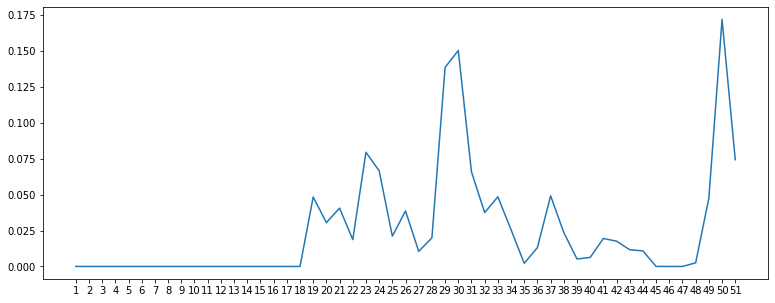

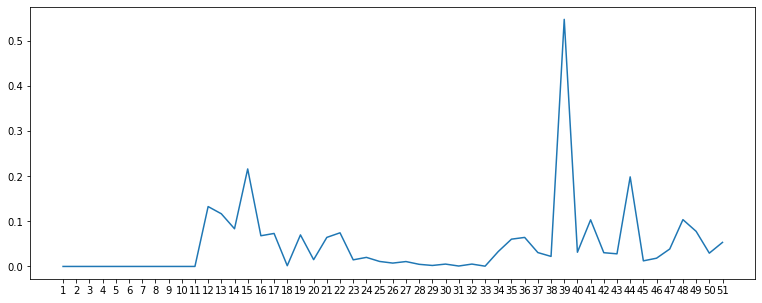

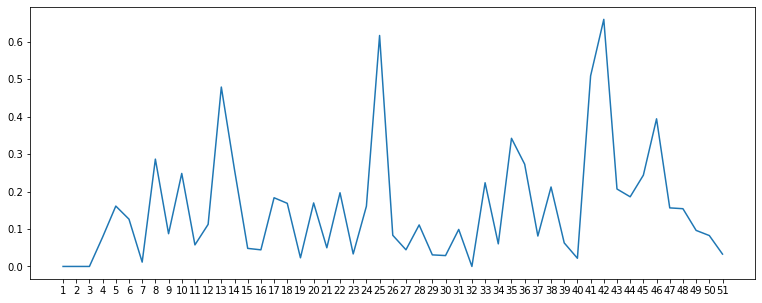

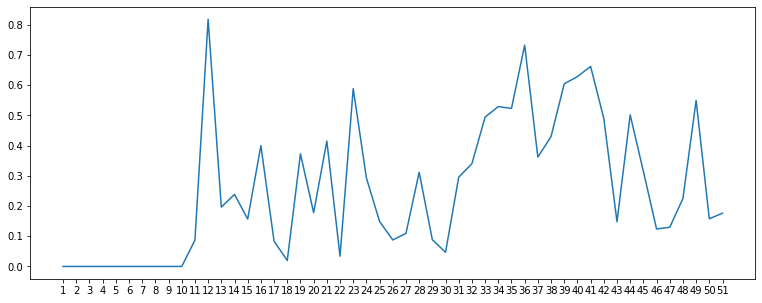

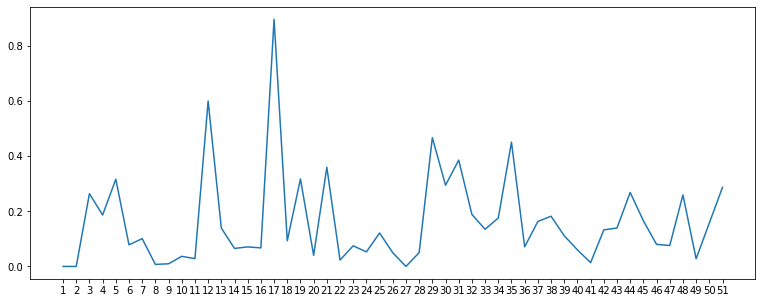

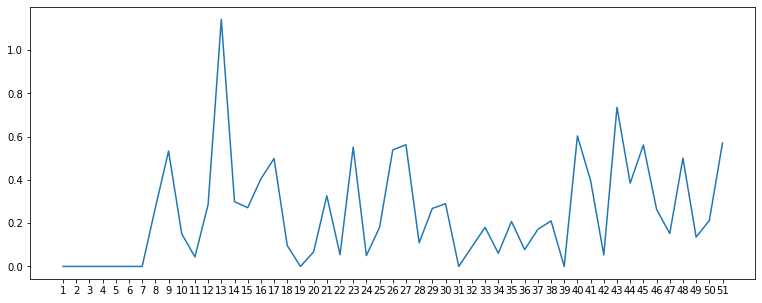

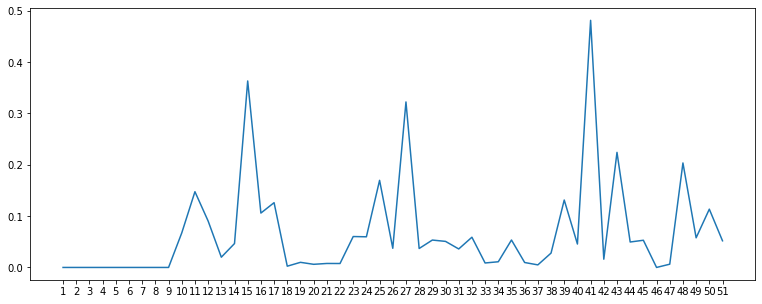

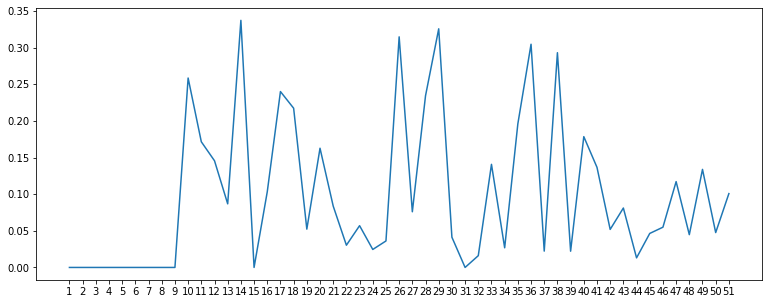

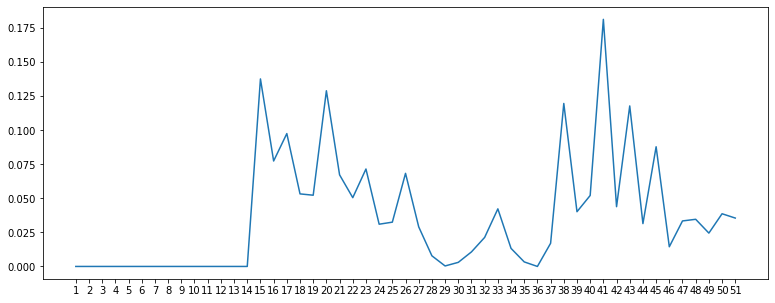

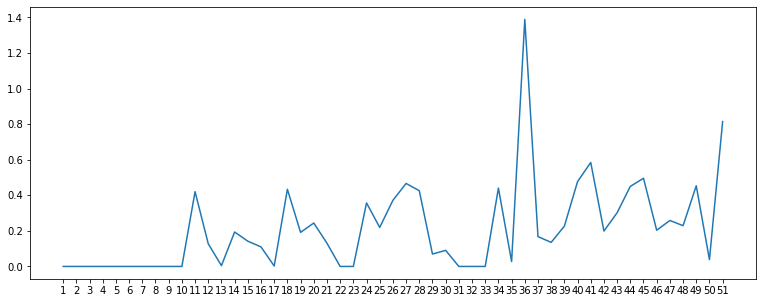

In [60]:
ordered_evals = dict()
for ego in users:
    plt.figure(figsize=(13,5))
    plt.xticks(np.arange(0,51), np.arange(1,52))

    ordered_evals[ego] = np.argsort(eigens[ego][0])   # gets the indexes ordered by their value, to sort eigenvectors and eigenvalues 
    plt.plot(np.diff(eigens[ego][0][ordered_evals[ego]])[:51])
    plt.show()

The optimal number of clusteres should be the one leading to the first peak in the eigengap. Based on the figures above, a dicitonary of optimal numbers under each ego Id can be arranged. 

In [48]:
n = {0:18,107:11,348:3,414:10,686:2,698:7,1684:9,1912:9,3437:14,3980:10}

## Clustering
### Grouping points based on the new representation

For each ego, the eigenvectors are sorted in the same way as the eigenvalues have been before, and each of the first n columns are chosen for the new lower rank representation. 

In [61]:
new_matrices = dict()
for ego,optimal in n.items():
    low_representation = eigens[ego][1][ordered_evals[ego]][:,:optimal]
    new_matrices[ego] = low_representation

For each ego, kmeans is applied to its lower rank representation. The ordered labels for each friend Id are stored in a dictionary as a list, under the ego Id. 

In [63]:
clusters = dict()
for ego,optimal in n.items():
    kmeans = KMeans(optimal)
    kmeans.fit(new_matrices[ego])
    my_clusters = list(kmeans.labels_)
    clusters[ego] = my_clusters

## Evaluating Results
### Similarity of the resulting clusters to the gold standard

Processing the user defined circles by assigning the index corresponding to the id in an array to the number of the line (= number of the cluster) it appears in the file. This method assigns the friend to the last cluster it appears in.  

In [64]:
goldens = dict()
for ego in users:
    with open("facebook/" + str(ego) +".circles") as f:
        gold_std = np.zeros(len(friends_lists[ego]))
        i = 0
        for line in f:
            i+=1
            l = line.split("\t")[1:]
            for friend in l:
                gold_std[friends_lists[ego].index(int(friend))] = i

    gold_std = list(gold_std)
    goldens[ego] = gold_std

Because some friends don't appear in any cluster, they should be disregarded from both arrays.

In [65]:
for ego in users:
    for idx in sorted([idx for idx,cluster in enumerate(goldens[ego]) if cluster == 0],reverse=True):
        del clusters[ego][idx]
        del goldens[ego][idx]

Final scores.

In [68]:
for ego in users:
    print(adjusted_rand_score(clusters[ego], goldens[ego]))

0.0353207521407879
-0.0030229699189362374
0.004427468691895034
0.00011649828394643979
-0.0012599477460146238
0.2213140321438573
0.011182130149745789
0.0029515561847745834
0.0
0.19729251239818144


## Weighted Graph

### Pre-Processing
#### Constructing a Laplacian matrix to represent the graph 

#### Jaccard Similarities

In [73]:
features_list = dict()                                      # dictionary {ego:{id:[features list]}}
for ego in users:
    with open("facebook/" + str(ego) +".feat") as f:
        for line in f:
            l = list(map(int, line.split(" ")))
            if ego not in features_list:
                features_list[ego] = dict()
            features_list[ego][l[0]] = l[1:]

#### Adjacency Matrix

For the adjacency matrix, each row/column index matches the friend's index in the friend list. For each edge in the file, both Aij and Aji are be passed to the edge's weight.

In [75]:
a_matrices = dict()

for ego in users:
    adj_matrix = np.zeros((len(friends_lists[ego]), len(friends_lists[ego])))

    # adding the edges from the edges file, symetrically
    for edge in edges_lists[ego]:
        weight = jaccard_score(features_list[ego][edge[0]],features_list[ego][edge[1]])
        adj_matrix[friends_lists[ego].index(edge[0])][friends_lists[ego].index(edge[1])] = weight
        adj_matrix[friends_lists[ego].index(edge[1])][friends_lists[ego].index(edge[0])] = weight
    
    a_matrices[ego] = adj_matrix

#### Degree Matrix

The degree matrix can be constructed by summing the values in the correspondent columns/rows on the adjacency matrix. The values are placed in the Aii cell, making it a diagonal matrix. 

In [76]:
d_matrices = dict()

for ego in users:
    deg_matrix = np.zeros((len(friends_lists[ego]), len(friends_lists[ego])))

    # diagonal matrix with the sum of correspondent row/column in adjacency matrix
    for row_idx in range(len(a_matrices[ego])):
        deg_matrix[row_idx][row_idx] = np.sum(a_matrices[ego][row_idx])

    d_matrices[ego] = deg_matrix

#### Laplacian Matrix

L = D - A

In [77]:
lap_decomposition = dict()

for ego in users:
    matrix = np.subtract(d_matrices[ego], a_matrices[ego])
    lap_decomposition[ego] = matrix
    print(matrix)

[[ 4.77546898  0.          0.         ...  0.         -0.04761905
   0.        ]
 [ 0.          1.44576061  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          4.15865934 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.10672391  0.
   0.        ]
 [-0.04761905  0.          0.         ...  0.          5.54185037
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.58127115]]
[[ 0.34285714 -0.2        -0.14285714 ...  0.          0.
   0.        ]
 [-0.2         1.04033613 -0.41176471 ...  0.          0.
   0.        ]
 [-0.14285714 -0.41176471  3.6900695  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  9.67920863  0.
  -0.42105263]
 [ 0.          0.          0.         ...  0.          4.7110028
   0.        ]
 [ 0.          0.          0.         ... -0.42105263  0.
  10.62934102]]
[[ 0.6461039  -0.21428571  0.         ...  0.          0.
   0.        ]
 [-0.21428571  1

### Decomposition
#### Computing eigenvalues and eigenvectors of the matrix 

### Determining the Number of Clusters
#### Using the eigengap approach

For each eigenvalues vector, the difference between successive sorted values is plotted.

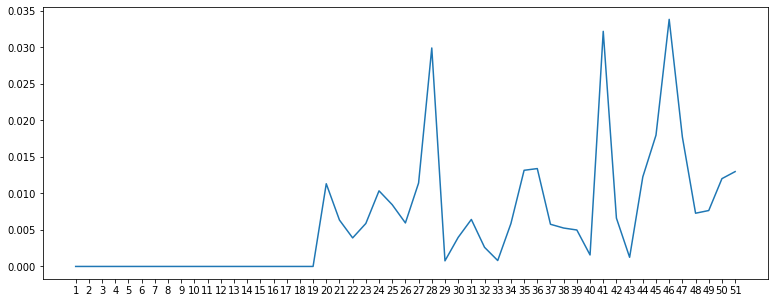

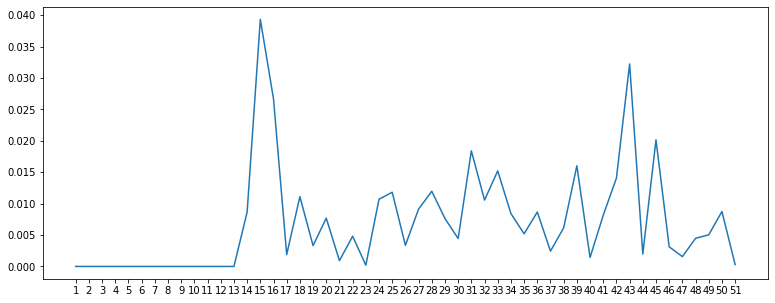

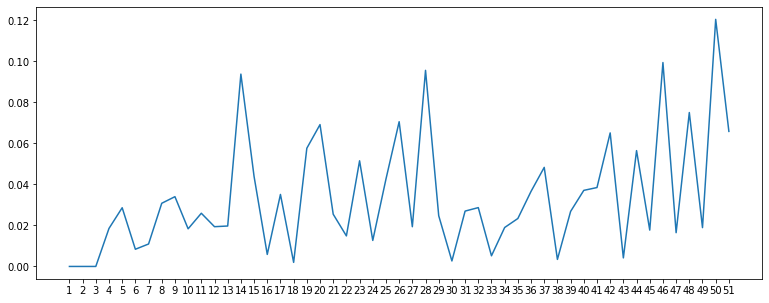

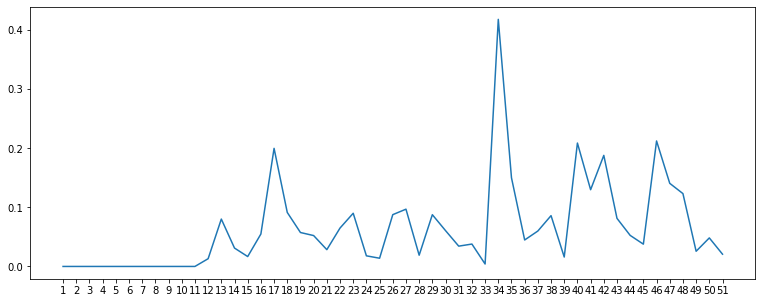

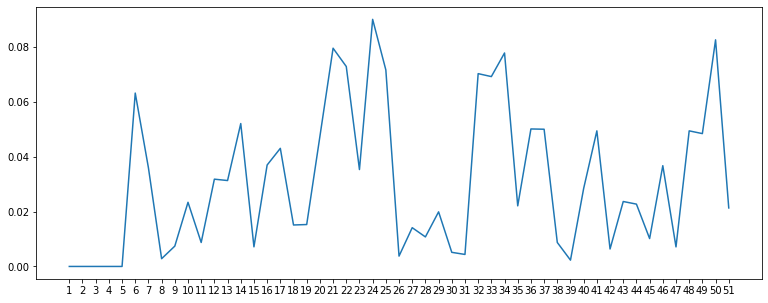

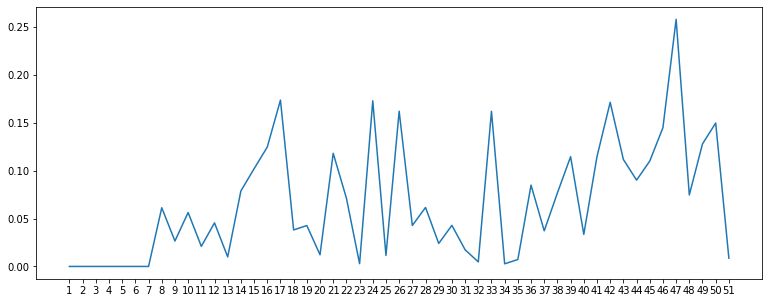

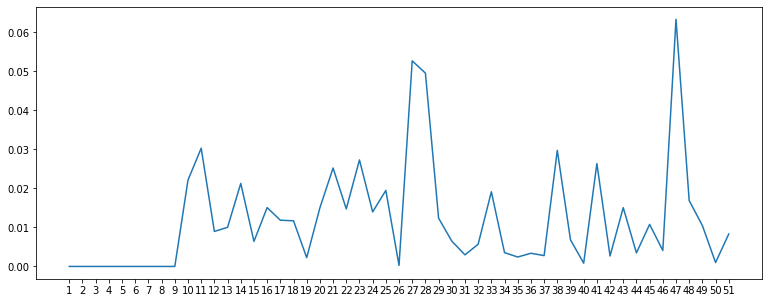

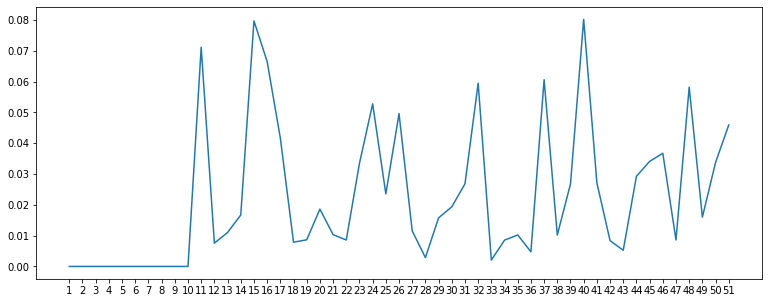

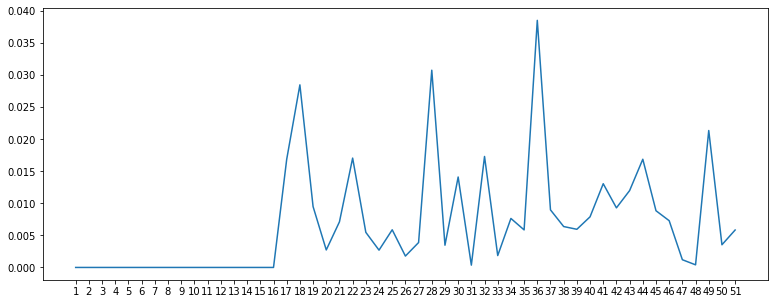

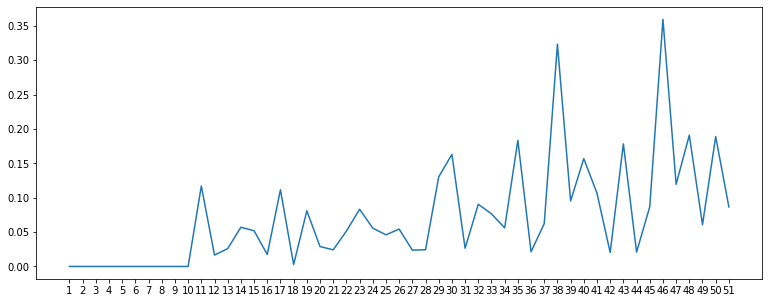

In [79]:
ordered_evals = dict()
for ego in users:
    plt.figure(figsize=(13,5))
    plt.xticks(np.arange(0,51), np.arange(1,52))

    ordered_evals[ego] = np.argsort(eigens[ego][0])   # gets the indexes ordered by their value, to sort eigenvectors and eigenvalues 
    plt.plot(np.diff(eigens[ego][0][ordered_evals[ego]])[:51])
    plt.show()

The optimal number of clusters changes somewhat.

In [81]:
n = {0:19,107:13,348:3,414:11,686:5,698:7,1684:9,1912:10,3437:16,3980:10}

### Clustering
#### Grouping points based on the new representation

For each ego, the eigenvectors are sorted in the same way as the eigenvalues have been before, and each of the first n columns are chosen for the new lower rank representation. 

In [82]:
new_matrices = dict()
for ego,optimal in n.items():
    low_representation = eigens[ego][1][ordered_evals[ego]][:,:optimal]
    new_matrices[ego] = low_representation

For each ego, kmeans is applied to its lower rank representation. The ordered labels for each friend Id are stored in a dictionary as a list, under the ego Id. 

In [83]:
clusters = dict()
for ego,optimal in n.items():
    kmeans = KMeans(optimal)
    kmeans.fit(new_matrices[ego])
    my_clusters = list(kmeans.labels_)
    clusters[ego] = my_clusters

Calculating the eigenvalues and eigenvectors for each laplacian matrix, and storing them as a list under the ego key.

In [84]:
eigens = dict()
for ego in users:
    eigenvals, eigenvects = np.linalg.eigh(lap_decomposition[ego])
    eigens[ego] = [eigenvals, eigenvects]
    print(eigenvals.shape,eigenvects.shape)

(347,) (347, 347)
(1045,) (1045, 1045)
(227,) (227, 227)
(159,) (159, 159)
(170,) (170, 170)
(66,) (66, 66)
(792,) (792, 792)
(755,) (755, 755)
(547,) (547, 547)
(59,) (59, 59)


### Evaluating Results
#### Similarity of the resulting clusters to the gold standard

In [85]:
goldens = dict()
for ego in users:
    with open("facebook/" + str(ego) +".circles") as f:
        gold_std = np.zeros(len(friends_lists[ego]))
        i = 0
        for line in f:
            i+=1
            l = line.split("\t")[1:]
            for friend in l:
                gold_std[friends_lists[ego].index(int(friend))] = i

    gold_std = list(gold_std)
    goldens[ego] = gold_std

In [86]:
for ego in users:
    for idx in sorted([idx for idx,cluster in enumerate(goldens[ego]) if cluster == 0],reverse=True):
        del clusters[ego][idx]
        del goldens[ego][idx]

In [87]:
for ego in users:
    print(adjusted_rand_score(clusters[ego], goldens[ego]))

0.02749444479982735
-0.0030229699189362374
0.004427468691895034
-0.004374020966773004
0.008058723207685399
0.2280296230580228
0.011382303308109645
0.006042234768466638
0.0
0.15718566979901916
